# HPGE Gamma Spectroscopy - Spectral Analysis

In [161]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
import pandas as pd

In [9]:
class spectra:
    def __init__(self, filename):
        self.chan, self.energy, self.count= np.loadtxt('spectra/Background_16_10_23_Mon_14_50_edited.csv',delimiter = ',',skiprows=3,unpack = True)

chan_bg_spec,E_bg_spec,C_bg_spec = np.loadtxt('spectra/Background_16_10_23_Mon_14_50.csv',delimiter = ',',skiprows=7,unpack = True)
peaks, _ =signal.find_peaks(C_bg_spec)

In [83]:
def chi2_prob(fit,data,err,df):
    '''This function calculates chi2 probability for given 
       fit array, data array,err and degrees of freedom 
       Inputs: fit  - array of fitted values
               data - array of original data
               err  - error 
               df   - degree of freedom
       Outputs: chi2 probability, 
       the probability of obtaining a value of minimized chi2 
       equal to the fit value or higher, given df'''
    norm_resid = (fit -data)/err #normalized residual
    chi2 = np.sum(norm_resid**2) #chi-square
    chi2_p = 1-stats.chi2.cdf(chi2,df) #chi2 probability =  1-cumulative distribution function
    return chi2_p

In [20]:
bg = pd.read_csv('spectra/Background_16_10_23_Mon_14_50.csv',delimiter = ',')

In [ ]:
pk_bg = np.loadtxt('spectra/Background_16_10_23_Mon_14_50.csv',delimiter = ',',skiprows=7,unpack = True)

FWHM of Gaussian = $2\sqrt{2\ln{2}}\sigma$, where $\sigma$ is standard deviation. \
Error in centroid of Gaussian can be given by standard error on mean, which is $\sigma/\sqrt{n}$. \
$n$ is the number of samples, i.e. total no. of counts under the peak in this  case

Loading peak data csv into pd.DataFrame

In [106]:
peak_1 = pd.read_csv('peaks/peaks_Sample1_30_10_23_Mon_09_22.CSV',delimiter = ',')
centroid_1, ref_1, fwhm_1, peak_count_1= peak_1[['Centroid',' Photopeak_Energy',' FWHM',' ROI_Total']][1:].dropna().to_numpy(dtype = float).transpose()
centroid_1_err = fwhm_1/2/np.sqrt(2*np.log(2)*peak_count_1) #centroid error

In [78]:
energy, count = np.loadtxt('spectra/Sample1_24_10_23_Mon_15_27.csv',delimiter = ',', skiprows = 3,unpack = True)

## Energy Calibration

In [143]:
#convert peak energy to channel number (fraction of channel number) using Lynx calibration
#Lynx calibration: energy = grad * channel# + interc
grad = 0.6775230169 #gradient
interc = -0.3439140022 #intercept
energy_to_chan = np.poly1d([1/grad,-interc/grad])


Text(1, 2200, 'Error bars are too small to be displayed')

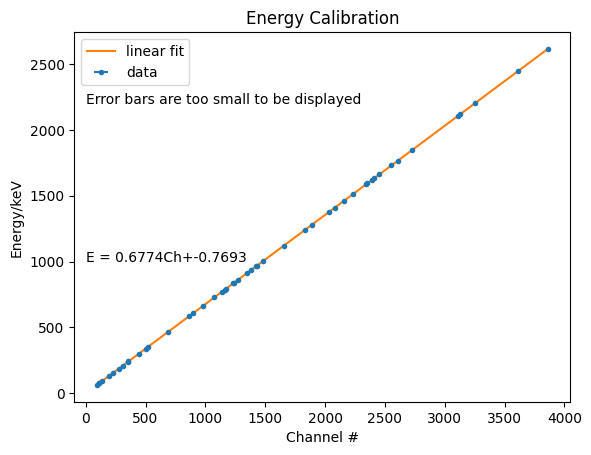

In [156]:
y = ref_1
x = energy_to_chan(centroid_1)
popt_peak, pcov_peak = np.polyfit(x,y,1,cov = True) #energy callibration using peak
perr_peak = np.sqrt(np.diag(pcov_peak))
peak_fit = np.poly1d(popt_peak)
x_err = popt_peak[0]*centroid_1_err
#errorbars are too small to be displayed
plt.title('Energy Calibration')
plt.errorbar(x,y,xerr= x_err, fmt = '.',label = 'data')
plt.plot(x,peak_fit(x),label = 'linear fit')
plt.legend()
plt.xlabel('Channel #')
plt.ylabel('Energy/keV')
plt.text(1,1000,f'E = {popt_peak[0]:.4f}Ch+{popt_peak[1]:.4f}')
plt.text(1,2200,'Error bars are too small to be displayed')

In [158]:
print(f'Linear fit (channel to energy) using peak energy: E = {popt_peak[0]:.6f}Ch {popt_peak[1]:.6f}')
print(f'Original linear fit (channel to energy) : E = {grad:.6f}Ch {interc:.6f}' )
print('Errors on new fit:')
print(perr_peak)

Linear fit (channel to energy) using peak energy: E = 0.677361Ch -0.769329
Original linear fit (channel to energy) : E = 0.677523Ch -0.343914
Errors on new fit:
[2.75942194e-05 4.97429035e-02]


Text(0, 0.5, 'Reference Peak Energy-Peak Centroid/keV')

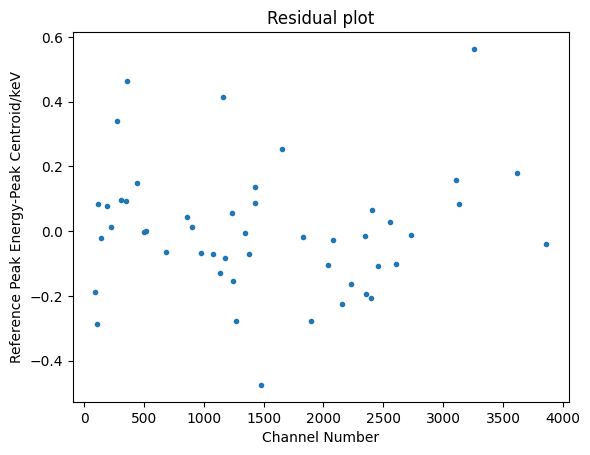

In [146]:
plt.figure()
plt.title('Residual plot')
plt.plot(x,(y-peak_fit(x)),'.')
plt.xlabel('Channel Number')
plt.ylabel('Reference Peak Energy-Peak Centroid/keV')

## Resolution Calibration

Resolution = $\frac{FWHM}{E_0}$,
where $FWHM = \sqrt{a \times E_0+b}$, a

/var/folders/vh/bwtbn9cn1xlbm74kxlygt5b80000gn/T/ipykernel_21177/3173079030.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(a*peak_energy+b)/peak_energy


Text(1600, 0.014, 'b =1.8$\\pm$0.114')

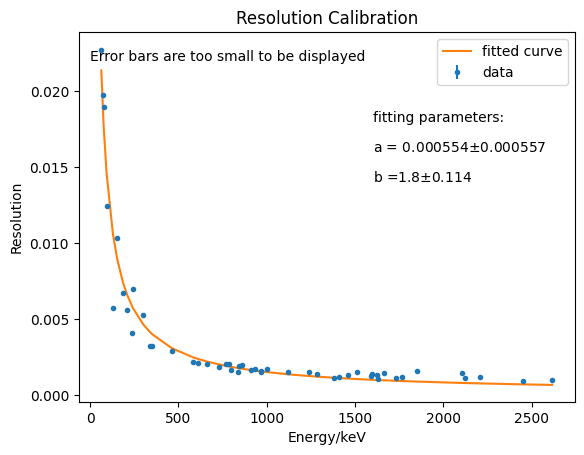

In [185]:
res = fwhm_1/centroid_1
fwhm_1_err= fwhm_1/np.sqrt(2*peak_count_1)

res_err = res*np.sqrt((centroid_1_err/centroid_1)**2+(fwhm_1_err/fwhm_1)**2)
def res_fit(peak_energy,a,b):
    '''This function is used for fitting resolution as a function of energy
       res = np.sqrt(a*energy+b)/energy
       Input:  peak_energy - fitted centroid of labelled peaks
               a,b         - parameters for the above formula
       Output: resolution
       '''
    return np.sqrt(a*peak_energy+b)/peak_energy
res_par, res_cov = curve_fit(res_fit,centroid_1,res)
res_fit_err = np.sqrt(np.diag(res_cov))


plt.figure()
plt.title('Resolution Calibration')
plt.errorbar(centroid_1,res,yerr = res_err,fmt = '.',label = 'data')
plt.plot(centroid_1,res_fit(centroid_1,*res_par), label = 'fitted curve')
plt.ylabel('Resolution')
plt.xlabel('Energy/keV')
plt.legend()
plt.text(1,0.022,'Error bars are too small to be displayed')
plt.text(1600,0.018,f'fitting parameters:')
plt.text(1600,0.016,f'a = {res_par[0]:.3g}' + r'$\pm$'+ f'{res_fit_err[0]:.3g}')
plt.text(1600,0.014,f'b ={res_par[1]:.3g}' + r'$\pm$'+ f'{res_fit_err[1]:.3g}')

In [169]:
centroid_1

array([  63.49,   75.55,   77.47,   93.27,  129.44,  154.43,  186.34,
        209.63,  239.02,  242.02,  300.44,  338.83,  352.44,  463.6 ,
        583.71,  609.87,  662.31,  728.  ,  769.1 ,  786.45,  795.65,
        836.28,  841.16,  861.47,  911.85,  934.78,  965.29,  969.54,
       1002.13, 1120.73, 1238.85, 1281.97, 1378.53, 1408.77, 1461.75,
       1510.18, 1589.02, 1593.54, 1621.52, 1631.38, 1662.21, 1730.4 ,
       1765.44, 1848.3 , 2104.3 , 2119.4 , 2204.6 , 2448.69, 2615.62])

In [168]:
res_par, res_cov = curve_fit(res_fit,centroid_1,res,[0.1,0.1])

TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

In [170]:
res_fit(centroid_1,2,3)